Dataset Shape: (569, 33)

First rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  p

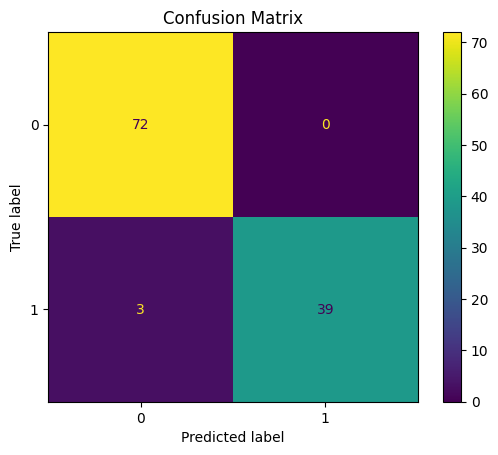

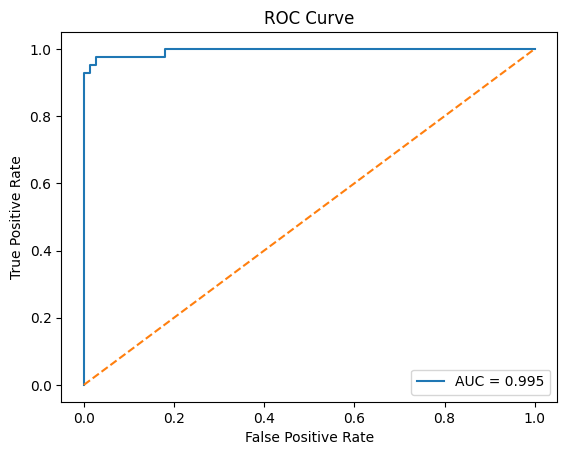

AUC Score: 0.9947089947089947
Model saved successfully.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
import joblib
df = pd.read_csv("data.csv")

print("Dataset Shape:", df.shape)
print("\nFirst rows:")
print(df.head())
print("\nClass distribution:")
print(df['diagnosis'].value_counts())
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)

if 'Unnamed: 32' in df.columns:
    df.drop(columns=['Unnamed: 32'], inplace=True)

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
svm_linear = SVC(kernel='linear', probability=True)
svm_linear.fit(X_train_scaled, y_train)

linear_acc = svm_linear.score(X_test_scaled, y_test)
print("\nLinear Kernel Accuracy:", linear_acc)
svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf.fit(X_train_scaled, y_train)

rbf_acc = svm_rbf.score(X_test_scaled, y_test)
print("RBF Kernel Accuracy:", rbf_acc)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001]
}

grid = GridSearchCV(
    SVC(kernel='rbf', probability=True),
    param_grid,
    cv=5,
    scoring='accuracy'
)

grid.fit(X_train_scaled, y_train)

print("\nBest Parameters:", grid.best_params_)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("Confusion Matrix")
plt.show()
y_prob = best_model.predict_proba(X_test_scaled)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("AUC Score:", auc_score)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', best_model)
])

pipeline.fit(X_train, y_train)

joblib.dump(pipeline, "svm_breast_cancer_model.pkl")
print("Model saved successfully.")